In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
data_path = "./data/"
data_files = {
  "Family":              "familyxx.csv",
  "Household":           "househld.csv",
  "Injury Episode":      "injpoiep.csv",
  "Person":              "personsx.csv",
  "Sample Child":        "samchild.csv",
  "Sample Adult":        "samadult.csv",
  "Sample Adult Cancer": "cancerxx.csv"
}

In [3]:
df = pd.read_csv(data_path + data_files["Person"])

In [4]:
military_indices = (
    (df.ARMFTM1P == 1) | # US military 2001 - ????
    (df.ARMFTM2P == 1) | # US military 1990 - 2001
    (df.ARMFTM3P == 1) | # US military 1975 - 1990
    (df.ARMFTM4P == 1) | # US military 1964 - 1975
    (df.ARMFTM5P == 1) | # US military 1955 - 1964
    (df.ARMFTM6P == 1) | # US military 1950 - 1955
    (df.ARMFTM7P == 1)   # US military ???? - 1950
)
was_military = df[ military_indices]
not_military = df[~military_indices]
len(was_military), len(not_military)

(6863, 96926)

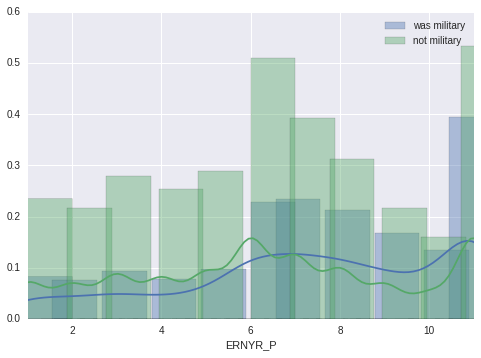

In [5]:
def get_incomes(df):
    return df[              # people who
        (df.WRKLYR1 == 1) & # worked last year
        (df.ERNYR_P < 12)   # and reported their earnings
    ].ERNYR_P               # were in these income brackets

y_incomes = get_incomes(was_military)
n_incomes = get_incomes(not_military)
plt.xlim(1, 11)
sns.distplot(y_incomes, label = "was military", hist_kws = {"width": 1})
sns.distplot(n_incomes, label = "not military", hist_kws = {"width": 1})
plt.legend()